<a href="https://colab.research.google.com/github/leowu4ever/PhD_Note/blob/master/ancon_sample_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data exploration**
*   There are totally 5 dataset files ('background', 'normal lung cells', 'lung cancer', 'leukaemia', 'example breath sample'
*   4286 retention time records for each dataset
*   4499 drift time records for each dataset


In [1]:
#@title Housekeeping { vertical-output: true, form-width: "30%" }
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Image
from google.colab import drive
drive.mount('/content/gdrive')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

folder_path = '/content/gdrive/My Drive/ancon_sample_dataset/'
file_names = {
    'BACKGROUND'            : '180411_042123_3.csv',
    'NORMAL_LUNG_CELLS'     : '180411_055221_3.csv',
    'LUNG_CANCER'           : '180411_071824_3.csv',
    'LEUKAEMIA'             : '180411_091900_3.csv',
    'EXAMPLE_BREATH_SAMPLE' : '180301_162330_3.csv'
}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#@title Dataset format description { vertical-output: true, form-width: "30%" }
Image('/content/gdrive/My Drive/ancon_sample_dataset/dataset_labels.png')
print ('drift times - Yellow')
print ('spectrum number - red')
print ('retention times - orange')
print ('intensity data - green')

for name in file_names:
  shape = pd.read_csv(folder_path + file_names[name], sep=';', index_col='#SpecNum').shape
  print(name + ' file\'s shape is' + str(shape))

In [0]:
#@title Show a dateset { vertical-output: true, form-width: "30%" }
file_selected = "BACKGROUND" #@param ["BACKGROUND", "NORMAL_LUNG_CELLS", "LUNG_CANCER", "LEUKAEMIA", "EXAMPLE_BREATH_SAMPLE"]

df = pd.read_csv(folder_path + file_names[file_selected], sep=';', index_col='RetTime [s] \\ DriftTime [ms]')
df.head(3)

Text(0.5, 15.0, 'Drift time[ms]')

Text(132.0, 0.5, 'Retention time[s]')

Text(0.5, 15.0, '')

Text(345.2620689655173, 0.5, '')

Text(0.5, 15.0, '')

Text(541.5241379310345, 0.5, '')

Text(0.5, 15.0, '')

Text(737.7862068965519, 0.5, '')

Text(0.5, 15.0, '')

Text(934.0482758620691, 0.5, '')

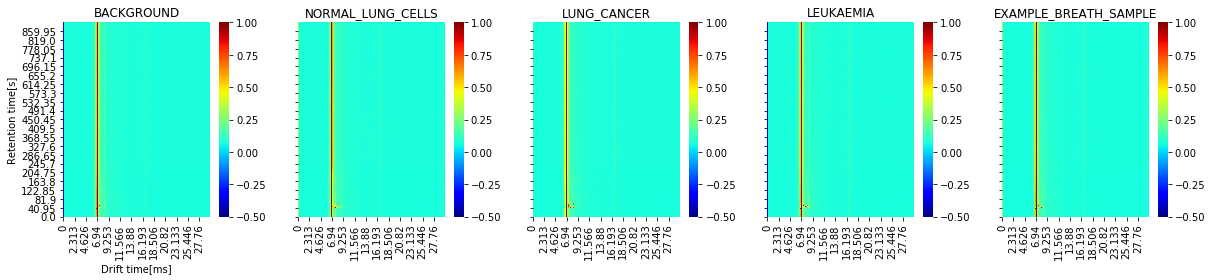

In [4]:
#@title Show spectra for all datasets { vertical-output: true, form-width: "30%" }
intensity_min_displayed = -0.5 #@param {type:"number"}
intensity_max_displayed = 1 #@param {type:"number"}

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17,4), sharex=True, sharey=True)
ax_count = 0

for name in file_names:
  df = pd.read_csv(folder_path + file_names[name], sep=';', index_col='RetTime [s] \\ DriftTime [ms]')
  df = df.drop(columns=['#SpecNum'])
  
  sns.heatmap(df, ax=axes[ax_count], vmin=intensity_min_displayed, vmax=intensity_max_displayed, cmap='jet')
  axes[ax_count].invert_yaxis()
  axes[ax_count].title.set_text(name)

  if(ax_count == 0): 
    axes[ax_count].set_xlabel('Drift time[ms]')
    axes[ax_count].set_ylabel('Retention time[s]')
  else:
    axes[ax_count].set_xlabel('')
    axes[ax_count].set_ylabel('')

  ax_count = ax_count + 1

plt.tight_layout()
plt.show()

<Figure size 1296x720 with 0 Axes>

Text(0.5, 66.5, 'Drift time[ms]')

Text(138.5, 0.5, 'Retention time[s]')

Text(0.5, 1.0, 'BACKGROUND')

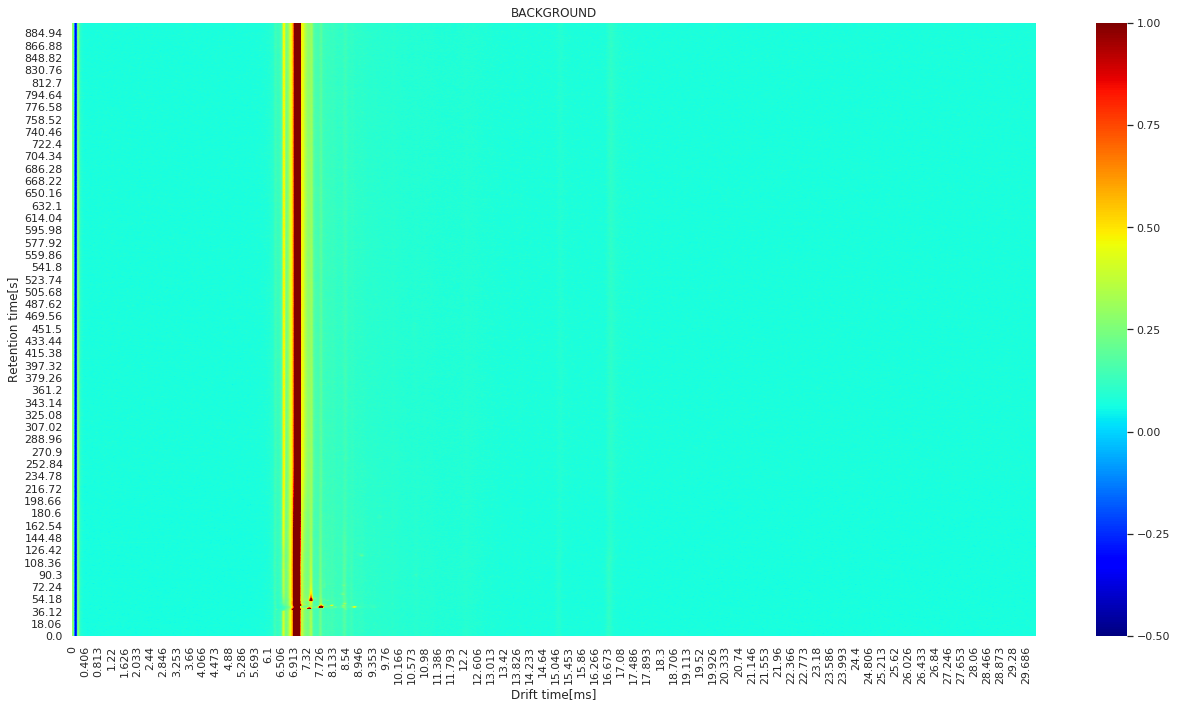

In [18]:
#@title Show spectra { vertical-output: true, form-width: "30%" }
file_selected = "BACKGROUND" #@param ["BACKGROUND", "NORMAL_LUNG_CELLS", "LUNG_CANCER", "LEUKAEMIA", "EXAMPLE_BREATH_SAMPLE"]
plot_selected = "Spectra" #@param ["Spectra", "Distribution"]

width = 18 #@param {type:"integer"}
height = 10 #@param {type:"integer"}
intensity_min_displayed = -0.5 #@param {type:"number"}
intensity_max_displayed = 1 #@param {type:"number"}

df = pd.read_csv(folder_path + file_names[file_selected], sep=';', index_col='RetTime [s] \\ DriftTime [ms]')
df = df.drop(columns=['#SpecNum'])

if(plot_selected == 'Spectra'):
  plt.figure(figsize=(width,height))
  ax = sns.heatmap(df, vmin=intensity_min_displayed, vmax=intensity_max_displayed, cmap='jet')
  ax.invert_yaxis()
  plt.xlabel('Drift time[ms]')
  plt.ylabel('Retention time[s]')
  plt.title(file_selected)
  plt.tight_layout()

elif (plot_selected == 'Distribution'):
  intensity_array = df.values.flatten()
  plt.figure(figsize=(width,height))
  sns.set()
  sns.distplot(intensity_array)
  plt.ylim(bottom=-1)
  intensity_array_desc = stats.describe(intensity_array)
  intensity_min = str(round(intensity_array_desc.minmax[0],2))
  intensity_max = str(round(intensity_array_desc.minmax[1],2))
  intensity_mean = str(round(intensity_array_desc.mean, 2))

  plt.title('min_intensity: '+intensity_min + '\n '
          + 'max_intensity: '+intensity_max + '\n '
          + 'mean_intensity: '+intensity_mean)

# **Pre-processing**

Peak picking